In [1]:
# Install xgboost (run this once)
!pip install xgboost --quiet

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor  # Now this will work

print("xgboost installed and imported successfully!")

xgboost installed and imported successfully!


In [2]:
DATA_DIR = Path(r"E:\decision intelligent\task\3\Build a regression model to predict house prices based on multiple features\house-prices-advanced-regression-techniques")

# Read the CSV files instead of using read_excel:
train = pd.read_csv(DATA_DIR / "train.csv")  # Changed from read_excel to read_csv
test = pd.read_csv(DATA_DIR / "test.csv")    # Changed from read_excel to read_csv

y = train["SalePrice"]
X = train.drop(columns=["SalePrice"])

In [3]:
null_count = X.isna().sum().sort_values(ascending=False)
display(null_count[null_count > 0].to_frame("missing"))

num_feats = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_feats = X.select_dtypes(include=["object"]).columns.tolist()
print(f"{len(num_feats)} numeric, {len(cat_feats)} categorical features")


,missing
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageCond,81
GarageType,81
GarageYrBlt,81


37 numeric, 43 categorical features


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Define log_transformer using FunctionTransformer
# Using np.log1p which is log(1+x) to handle zeros safely
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Numeric pipeline: log-transform → median-impute → standardize
numeric_pipeline = Pipeline([
    ("log",     log_transformer),
    ("impute",  SimpleImputer(strategy="median")),
    ("scale",   StandardScaler()),
])

# Categorical pipeline: constant-impute → one-hot encode
categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("ohe",    OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

# Combine into one preprocessor
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline,     num_feats),
    ("cat", categorical_pipeline, cat_feats),
], remainder="drop")

In [5]:
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Create proper preprocessor that handles both numeric and categorical data
# Assuming X contains both numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessor with separate transformers for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Wrap Ridge so predictions are always ≥0
ridge_ttr = TransformedTargetRegressor(
    regressor=Ridge(alpha=1.0),
    func=np.log1p,
    inverse_func=np.expm1
)

models = {
    "Ridge": ridge_ttr,
    "RF":     RandomForestRegressor(n_estimators=100, random_state=42)
}

def rmsle_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    neg_mse = cross_val_score(
        Pipeline([("prep", preprocessor), ("model", model)]),
        X, y,
        scoring="neg_mean_squared_log_error",
        cv=cv,
        n_jobs=-1,
    )
    return np.sqrt(-neg_mse)

for name, mdl in models.items():
    scores = rmsle_cv(mdl)
    print(f"{name:10s} RMSLE: {scores.mean():.4f} ± {scores.std():.4f}")

Ridge      RMSLE: 0.1565 ± 0.0458
RF         RMSLE: 0.1471 ± 0.0198


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

rf_pipe = Pipeline([
    ("prep",  preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipe.fit(X, y)

# pull out one-hot names
# Directly access the OneHotEncoder without assuming it's in a named_steps structure
ohe_names = (
    rf_pipe.named_steps["prep"]
           .named_transformers_["cat"]  # This is likely the OneHotEncoder directly
           .get_feature_names_out(cat_feats)
)

all_feats   = num_feats + list(ohe_names)
importances = rf_pipe.named_steps["model"].feature_importances_
feat_imp    = pd.Series(importances, index=all_feats).sort_values(ascending=False)

print("Top 20 features by importance:")
print(feat_imp.head(20))

Top 20 features by importance:
OverallQual     0.580150
GrLivArea       0.108067
TotalBsmtSF     0.036088
2ndFlrSF        0.031041
BsmtFinSF1      0.030640
GarageCars      0.025380
1stFlrSF        0.024592
GarageArea      0.012096
LotArea         0.011978
YearBuilt       0.008382
FullBath        0.007964
YearRemodAdd    0.006762
LotFrontage     0.006104
MasVnrArea      0.006041
TotRmsAbvGrd    0.005859
GarageYrBlt     0.004744
OpenPorchSF     0.004542
BsmtUnfSF       0.004345
WoodDeckSF      0.004256
Id              0.004212
dtype: float64


In [8]:
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth":    [None, 10, 20, 30],
    # 'auto' is invalid in newer sklearn—use None, 'sqrt', or 'log2'
    "model__max_features": [None, "sqrt", "log2"],
}

grid_rf = GridSearchCV(
    Pipeline([("prep", preprocessor),
              ("model", RandomForestRegressor(random_state=42))]),
    param_grid,
    cv=3,
    scoring="neg_mean_squared_log_error",
    n_jobs=-1
)
grid_rf.fit(X, y)

best_rf_rmsle = np.sqrt(-grid_rf.best_score_)
print("Best RF params:", grid_rf.best_params_)
print(f"RF CV RMSLE: {best_rf_rmsle:.4f}")


Best RF params: {'model__max_depth': None, 'model__max_features': None, 'model__n_estimators': 300}
RF CV RMSLE: 0.1486


In [11]:
# Step 8: XGBoost tuning (will safely skip if XGBoost isn't installed)

# 1) Define/check availability
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

# 2) If available, run RandomizedSearchCV
if xgb_available:
    from scipy.stats import randint, uniform
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import RandomizedSearchCV
    import numpy as np

    xgb_pipe = Pipeline([
        ("prep",  preprocessor),
        ("model", XGBRegressor(random_state=42, verbosity=0))
    ])

    param_dist = {
        "model__n_estimators": randint(100, 500),
        "model__learning_rate": uniform(0.01, 0.3),
        "model__max_depth":     randint(3, 10),
    }

    rand_xgb = RandomizedSearchCV(
        xgb_pipe,
        param_dist,
        n_iter=20,
        cv=3,
        scoring="neg_mean_squared_log_error",
        random_state=42,
        n_jobs=-1
    )
    rand_xgb.fit(X, y)

    best_xgb_rmsle = np.sqrt(-rand_xgb.best_score_)
    print("Best XGB params:", rand_xgb.best_params_)
    print(f"XGB CV RMSLE: {best_xgb_rmsle:.4f}")
else:
    print("Skipping XGBoost tuning (xgboost not installed).")


Best XGB params: {'model__learning_rate': 0.05680559213273095, 'model__max_depth': 5, 'model__n_estimators': 314}
XGB CV RMSLE: 0.1371


In [12]:
import pandas as pd
import numpy as np

# 1) Choose your best pipeline
#    If you ran XGB and it beat RF, use rand_xgb; otherwise grid_rf
best_pipe = rand_xgb.best_estimator_ if (xgb_available and best_xgb_rmsle < best_rf_rmsle) else grid_rf.best_estimator_

# 2) Retrain on all training data
best_pipe.fit(X, y)

# 3) Predict on test set
preds = best_pipe.predict(test)

# 4) Build & save submission
submission = pd.DataFrame({
    "Id":         test["Id"],
    "SalePrice":  np.expm1(preds)   # undo any log1p you applied to SalePrice
})
submission.to_csv("submission.csv", index=False)
print("submission.csv saved!")


submission.csv saved!


C:\Users\DELL\AppData\Local\Temp\ipykernel_13144\2870919238.py:17: RuntimeWarning: overflow encountered in expm1
  "SalePrice":  np.expm1(preds)   # undo any log1p you applied to SalePrice


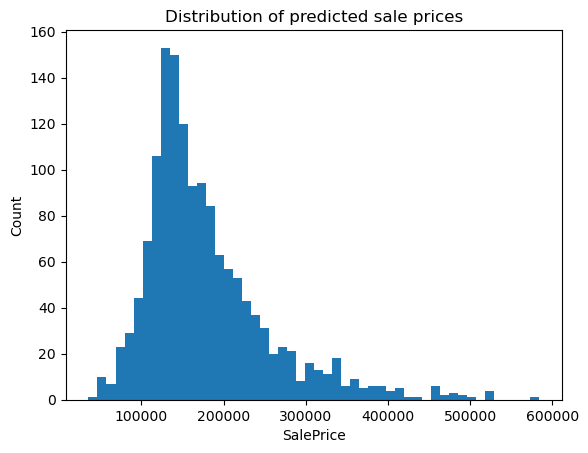

In [13]:
import matplotlib.pyplot as plt
plt.hist(preds, bins=50)
plt.title("Distribution of predicted sale prices")
plt.xlabel("SalePrice"); plt.ylabel("Count")
plt.show()


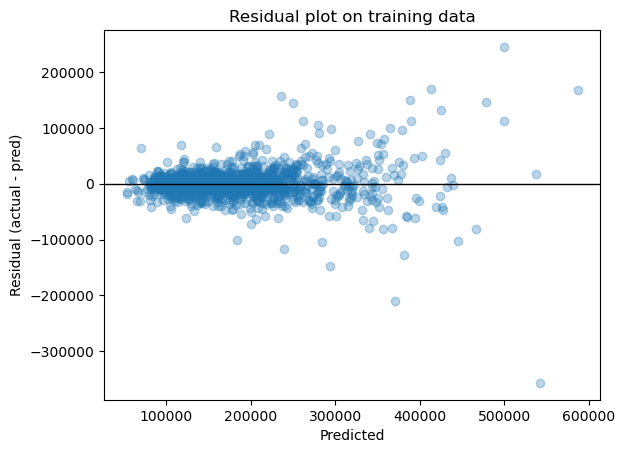

In [14]:
# get CV predictions on train
from sklearn.model_selection import cross_val_predict
oof_preds = cross_val_predict(best_pipe, X, y, cv=5, n_jobs=-1)

resid = y - oof_preds
plt.scatter(oof_preds, resid, alpha=0.3)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Predicted"); plt.ylabel("Residual (actual - pred)")
plt.title("Residual plot on training data")
plt.show()


In [15]:
import joblib
joblib.dump(best_pipe, "house_price_model.pkl")
print("Model pipeline saved to house_price_model.pkl")


Model pipeline saved to house_price_model.pkl


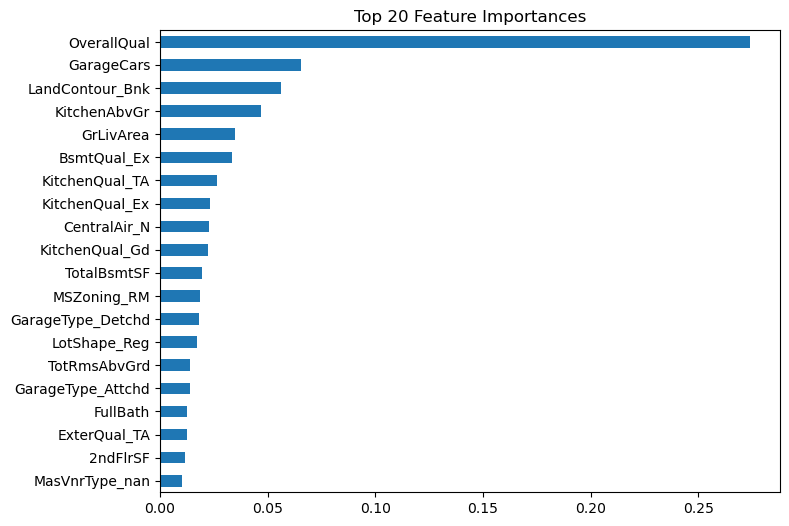

In [17]:
feat_imp = pd.Series(
    best_pipe.named_steps["model"].feature_importances_,
    index=num_feats + list(best_pipe.named_steps["prep"]
                                   .named_transformers_["cat"]
                                   .get_feature_names_out(cat_feats))
).sort_values(ascending=False).head(20)

feat_imp.plot.barh(figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.show()